In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import joblib
from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv('cleaned_online_retail_transactions.csv', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


### Cutoff Date

In [3]:
# Data before cutoff → features
# Data after cutoff → CLV target

cutoff_date = df['InvoiceDate'].max() - pd.DateOffset(months=6)

feature_df = df[df['InvoiceDate'] <= cutoff_date]
target_df  = df[df['InvoiceDate'] > cutoff_date]

### RFM Features

In [4]:
rfm = feature_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (cutoff_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum',
    'Quantity': 'sum'
}).reset_index()

rfm.columns = [
    'CustomerID',
    'Recency',
    'Frequency',
    'Monetary',
    'TotalQuantity'
]

In [5]:
# 6-Month CLV Target

clv_target = target_df.groupby('CustomerID')['TotalAmount'].sum().reset_index()
clv_target.columns = ['CustomerID', 'CLV_6M']

In [6]:
# Merge Features & Target

clv_data = rfm.merge(clv_target, on='CustomerID', how='left')
clv_data['CLV_6M'] = clv_data['CLV_6M'].fillna(0)

we use fill 0 because
Customers who didn’t buy in future window
Real-world churn behavior

In [7]:
# dataset splitting

X = clv_data[['Recency', 'Frequency', 'Monetary', 'TotalQuantity']]
y = clv_data['CLV_6M']
y_log = np.log1p(y)                    # log1p is used because CLV has zeros. 

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [8]:
models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

In [9]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)

    # Predict in log scale
    y_pred_log = model.predict(X_test)

    # Convert back to original CLV scale
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    })

results_df = pd.DataFrame(results).sort_values("MAE")
results_df

,Model,MAE,R2
3,GradientBoosting,819.508494,0.553039
2,RandomForest,827.390240,0.533320
1,DecisionTree,1361.041789,-4.095771
0,LinearRegression,32926.482765,-33980.378022


In [10]:
best_model = GradientBoostingRegressor(random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae = cross_val_score(
    best_model,
    X_train,
    y_train,
    scoring='neg_mean_absolute_error',
    cv=cv
)
print("CV MAE (log scale):", -cv_mae.mean())

CV MAE (log scale): 2.301720131667591


Cross-validation MAE is computed on log-transformed CLV values to ensure stability.
Final MAE is evaluated on the original monetary scale for business interpretability.

In [11]:
param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=15,
    scoring='neg_mean_absolute_error',
    cv=3,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

In [12]:
best_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": best_model.feature_importances_}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
2,Monetary,0.449831
3,TotalQuantity,0.296929
0,Recency,0.177105
1,Frequency,0.076136


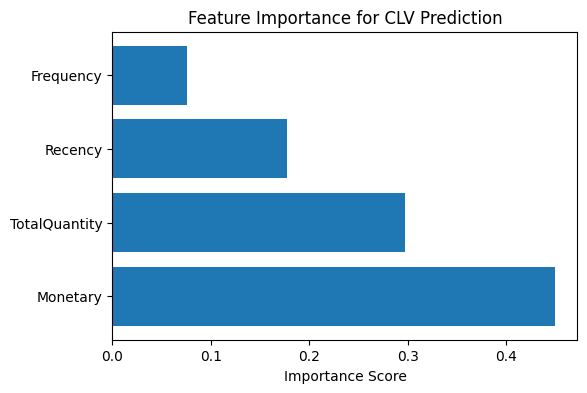

In [13]:
plt.figure(figsize=(6,4))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance for CLV Prediction')
plt.xlabel('Importance Score')
plt.show()

In [14]:
clv_data['Predicted_CLV'] = np.expm1(best_model.predict(X))

clv_data['CLV_Segment'] = pd.qcut(
    clv_data['Predicted_CLV'],
    q=[0, 0.7, 0.9, 1.0],
    labels=['Low', 'Medium', 'High']
)

In [15]:
baseline_mae = mean_absolute_error(y_true, np.full_like(y_true, y_true.mean()))

In [16]:
joblib.dump(X.columns.tolist(), "clv_features.pkl")
joblib.dump(best_model, "clv_model.pkl")

['clv_model.pkl']

In [17]:
clv_data.to_csv("clv_predictions.csv", index=False)